# Preparation

In [1]:
import glob
import json
import os
import random

import IPython
from IPython.display import HTML, display
import graphviz
import matplotlib.pyplot as plt
import nilearn.image as nimg
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from nilearn import plotting
from scipy.cluster._optimal_leaf_ordering import squareform
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn import tree
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from AAFM_service import AAFMService

import nibabel as nib

In [2]:
# load global vars
basedir = "/home/ymerel/storage/results/auditory"
mean_path = os.path.join(basedir, 'mean_result.nii')
df_path = os.path.join(basedir, 'dataset.csv')
corr_path = os.path.join(basedir, 'correlations.csv')
aafm_srv = AAFMService()
ids = []
results = []
paths = glob.glob(os.path.join(basedir, '*/'), recursive=True)
for path in paths:
    ids.append(os.path.basename(os.path.dirname(path)))
    results.append(os.path.join(path, '_subject_id_01', 'result.nii'))

# Show pipeline diagram

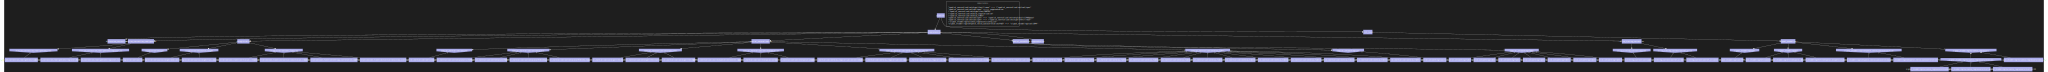

In [3]:
# Load the .dot file
with open('/home/ymerel/fmri-feature-model/model/uvl/full_pipeline.dot', 'r') as file:
    dot_data = file.read()

# Create a Graphviz Source object
src = graphviz.Source(dot_data)

# Render the graph to a file (e.g., PDF, PNG)
src.render('full_pipeline', format='png', cleanup=True)

# Display the graph (if using Jupyter Notebook)
src

# Load dataset
90 features + config hash (id) + correlation from ref + correlation from mean

In [4]:
# Mount group storage
!sshfs -o reconnect,ServerAliveInterval=120,ServerAliveCountMax=3 rennes.g5k:/srv/storage/empenn@storage2.rennes.grid5000.fr/private/ymerel /home/ymerel/storage
# load correlations
correlations = pd.read_csv(corr_path, delimiter=';')
matrix = correlations.pivot(index='source', columns='target', values='correlation').fillna(1.0)
distance_matrix = 1 - matrix

In [5]:
# write extended dataset (with mean of correlations, 10 random ref)
# Choose 10 random correlations as refs
def get_extended_dataset():
    unique_values = [value for value in correlations['source'].unique() if value not in ['ref', 'mean']]
    random_refs = random.sample(list(unique_values), 10)
    extended_dataset = pd.read_csv(df_path, delimiter=';')
    for ref in random_refs:
        print(f"Fetching correlations for random ref [{ref}]")
        for index, row in extended_dataset.iterrows():
            id_value = row['id']
            correlation = correlations.loc[
            (correlations['source'] == id_value) &
            (correlations['target'] == ref), 'correlation'].values[0]
            extended_dataset.at[index, f'from_{ref}'] = correlation
    print(f"Calculating mean of correlations for each config")
    for index, row in extended_dataset.iterrows():
            id_value = row['id']
            if id_value == 'ref' or id_value == 'mean':
                continue
            values = correlations.loc[
            (correlations['source'] == id_value) & (correlations['target'] != id_value) & (correlations['target'] != 'ref') & (correlations['target'] != 'mean'), 'correlation'].values
            extended_dataset.at[index, f'mean_corr'] =  sum(values) / len(values)
    # write dataset
    extended_dataset.to_csv(os.path.join(basedir, 'extended_dataset.csv'), index=False, sep=';')

# get_extended_dataset()

In [6]:
def clusterize(ids: list, nb_clusters: int):
    filtered_ds = dataset[dataset['id'].isin(ids)]
    filtered_corr = correlations[correlations['source'].isin(ids) & correlations['target'].isin(ids)]
    filtered_matrix = filtered_corr.pivot(index='source', columns='target', values='correlation').fillna(1.0)
    filtered_distance_matrix = 1 - filtered_matrix
    
    Z = linkage(squareform(filtered_distance_matrix), method='complete')
    clusters = fcluster(Z, nb_clusters, criterion='maxclust')
    
    matrix_df = pd.DataFrame(filtered_distance_matrix)
    matrix_df['cluster'] = clusters
    cluster_centroids = matrix_df.groupby('cluster').mean().mean(axis=1)
    sorted_clusters = cluster_centroids.sort_values().index
    consistent_label_mapping = {old_label: new_label + 1 for new_label, old_label in enumerate(sorted_clusters)}
    consistent_clusters = matrix_df['cluster'].map(consistent_label_mapping)

    mapping = pd.DataFrame({'config': filtered_distance_matrix.index, 'cluster': consistent_clusters})

    for id, row in mapping.iterrows():
        config = row['config']
        cluster = row['cluster']
        filtered_ds.loc[filtered_ds['id'] == config, 'cluster'] = int(cluster)
        
    filtered_ds = filtered_ds.sort_values(by='id', ascending=False)
    return filtered_ds, filtered_matrix, Z

# Clusterize all configurations

cluster
1.0    556
2.0    195
3.0    177
4.0     72
Name: count, dtype: int64


<Figure size 2000x2000 with 0 Axes>

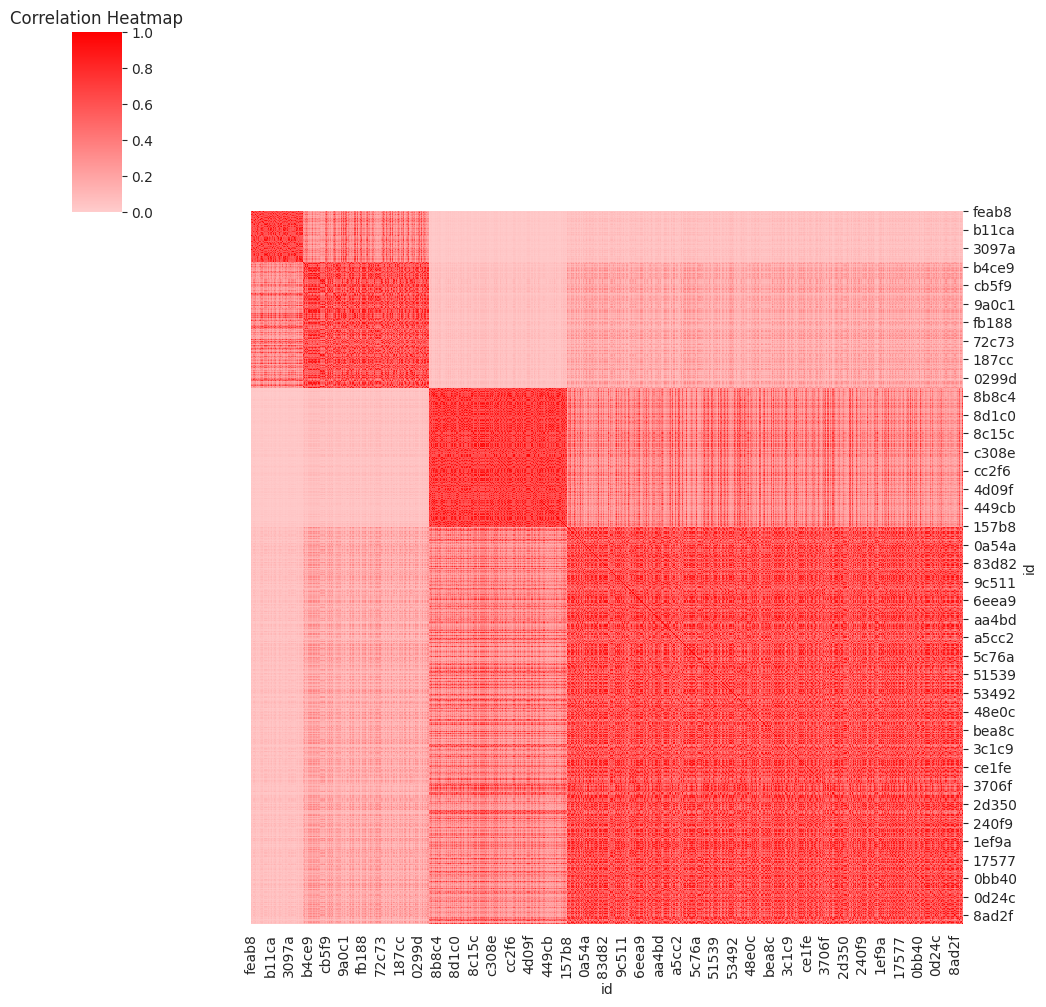

,spatial_smoothing/fwhm/12,spatial_smoothing/tool/spm,slice_timing_correction/ref_slice/middle,signal_modeling/hrf/temporal_dispersion_derivs,spatial_normalization/bias_fwhm/130,spatial_normalization/template,signal_modeling/hrf,signal_modeling/nuisance_regressors/motion/18,spatial_smoothing/fwhm/2,coregistration/cost_function/mutual_information,...,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6cc6ff25c55bfc81f210bb23,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746ad83ecbcc320c8fe4298a73,from_bdab21629030923da17e248d7689fc21eb1abea0d889d3b44c67b4baf6a07de5,from_6363ceb4ad5221e2fd865e8ba9181032905c33814f925c2e960adcd5354485e4,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705b65b17754f772d13f060284,from_6b4189bcd2f407a23e0ebc2d14de55529eaab1b0f5a612ba46b79d019b03cc46,from_c475f858fc2881ef01d1d4b705346000d23d56508ee89dcbf18e173daf48de57,from_5b935ba44056218711fe041d9e5000904a788b010f7c12dd70041a2e5cc4e135,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85a8971c44863127732e7026d,cluster
788,False,True,False,False,False,True,True,False,True,False,...,0.783977,0.781534,0.599326,0.602902,0.912298,0.336283,0.307697,0.286491,0.585972,2.0
183,False,True,False,False,False,True,True,False,False,False,...,0.041171,0.041733,0.048517,0.018959,0.032519,0.045156,0.061031,0.043576,0.044345,4.0
997,False,True,False,False,False,True,True,False,True,False,...,0.058683,0.059874,0.070860,0.022124,0.042624,0.062141,0.086790,0.062172,0.059310,4.0
602,False,True,True,True,False,True,True,True,False,False,...,0.347053,0.351272,0.450279,0.137710,0.251884,0.663299,0.877100,0.479385,0.487748,1.0
146,False,True,False,False,False,True,True,False,False,True,...,0.807899,0.808281,0.927870,0.330229,0.607472,0.535102,0.538319,0.518996,0.597510,1.0


In [7]:
dataset = pd.read_csv(os.path.join(basedir, 'extended_dataset.csv'), delimiter=';').drop(columns=['mean_corr'])
target_vars = [col for col in dataset.columns if col.startswith('from_')]

dataset, matrix, Z = clusterize(dataset["id"], 4)
cluster_counts = dataset['cluster'].value_counts()
print(cluster_counts)
plt.figure(figsize=(20, 20))
cmap = LinearSegmentedColormap.from_list("red_cmap", ["#FFCCCC", "#FF0000"])

# reorder matrix by cluster
sorted_index = dataset.sort_values('cluster', ascending=False)['id']
matrix = matrix.reindex(index=sorted_index, columns=sorted_index)
matrix.index = matrix.index.str.slice(0, 5)
matrix.columns = matrix.columns.str.slice(0, 5)
map = sb.clustermap(matrix, cmap=cmap, vmin=0, vmax=1, row_cluster=False, col_cluster=False, row_linkage=Z, col_linkage=Z)
plt.title('Correlation Heatmap')
plt.show()
dataset.head()

# Features repartition
Check features repartition for all configurations vs sample

Retrieved all [27648] configurations from [/home/ymerel/fmri-feature-model/model/uvl/full_pipeline.uvl]


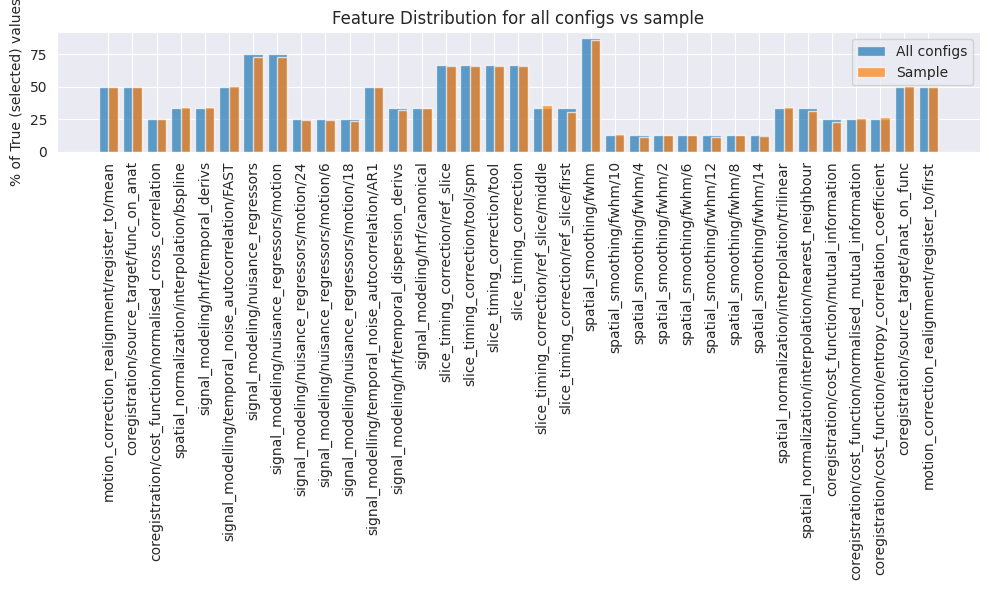

In [8]:
pd.set_option('future.no_silent_downcasting', True)
full = pd.DataFrame(aafm_srv.get_all_configs()).fillna(False).astype(bool)
full_rep = full.mean() * 100
full_rep = full_rep[(full_rep > 0) & (full_rep < 100)]
ignored = target_vars.copy()
ignored.append('id')
ignored.append('cluster')
sample_rep = dataset.drop(columns=ignored).mean() * 100
sample_rep = sample_rep[(full_rep > 0) & (sample_rep < 100)]
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the percentages for df1
ax.bar(full_rep.index, full_rep, alpha=0.7, label='All configs')

# Plot the percentages for df2
ax.bar(sample_rep.index, sample_rep, alpha=0.7, label='Sample', align='edge', width=0.4)

# Add labels and title
ax.set_ylabel('% of True (selected) values')
ax.set_title('Feature Distribution for all configs vs sample')
ax.legend()

# Show plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

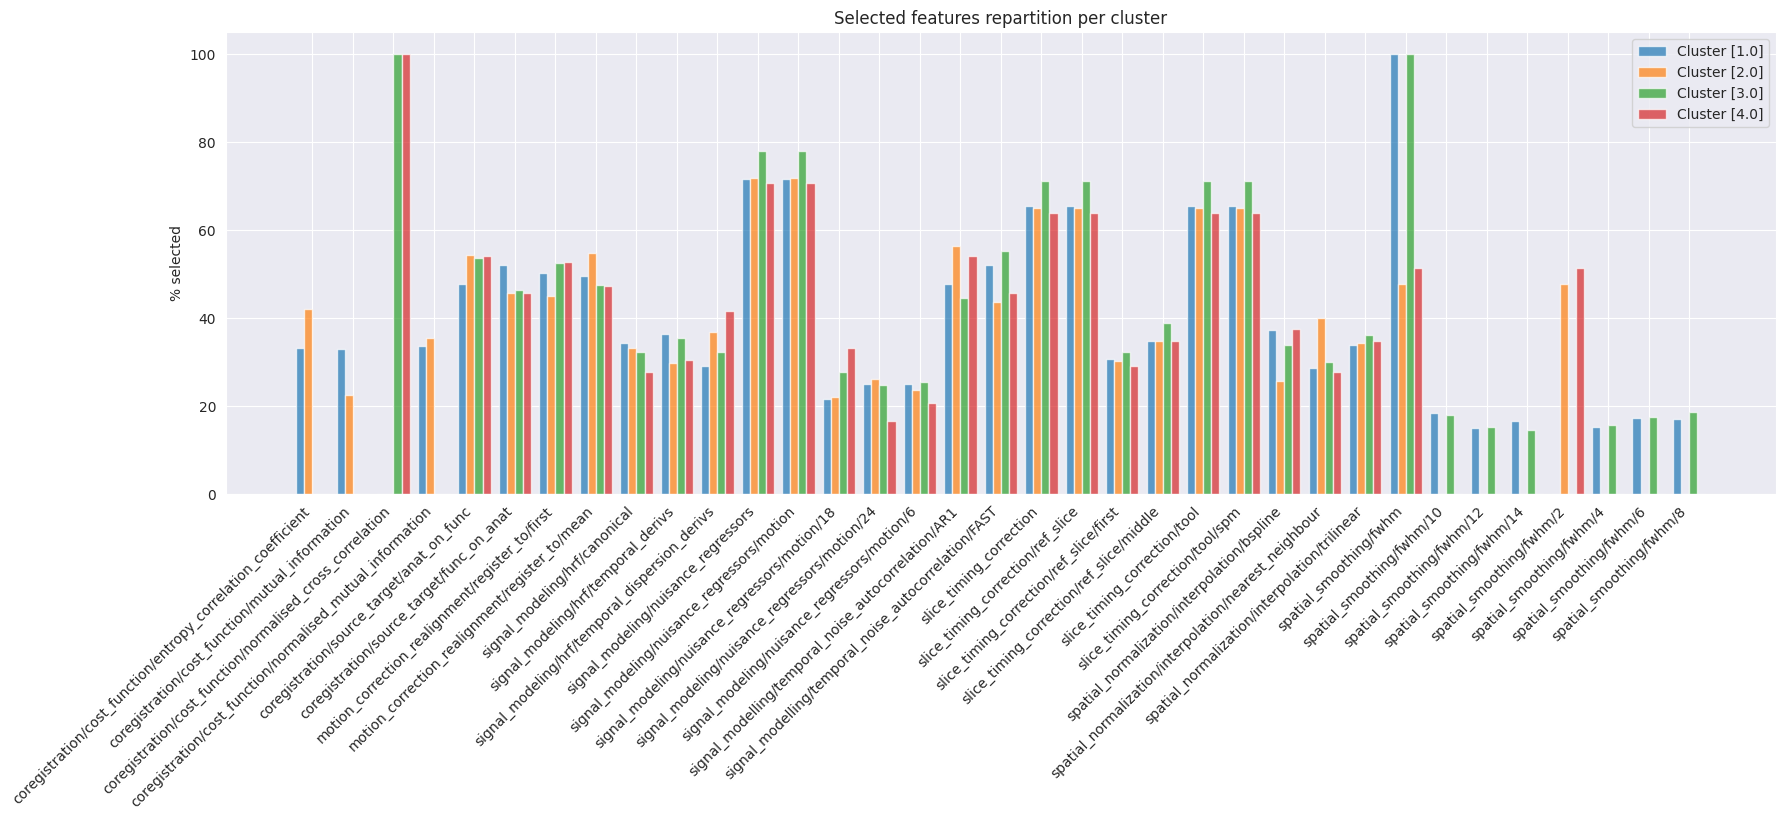

,coregistration/cost_function/entropy_correlation_coefficient,coregistration/cost_function/mutual_information,coregistration/cost_function/normalised_cross_correlation,coregistration/cost_function/normalised_mutual_information,coregistration/source_target/anat_on_func,coregistration/source_target/func_on_anat,motion_correction_realignment/register_to/first,motion_correction_realignment/register_to/mean,signal_modeling/hrf/canonical,signal_modeling/hrf/temporal_derivs,...,spatial_normalization/interpolation/nearest_neighbour,spatial_normalization/interpolation/trilinear,spatial_smoothing/fwhm,spatial_smoothing/fwhm/10,spatial_smoothing/fwhm/12,spatial_smoothing/fwhm/14,spatial_smoothing/fwhm/2,spatial_smoothing/fwhm/4,spatial_smoothing/fwhm/6,spatial_smoothing/fwhm/8
cluster,,,,,,,,,,,,,,,,,,,,,
1.0,33.273381,33.093525,0.0,33.633094,47.841727,52.158273,50.359712,49.640288,34.352518,36.510791,...,28.776978,33.812950,100.000000,18.525180,15.107914,16.726619,0.000000,15.287770,17.266187,17.086331
2.0,42.051282,22.564103,0.0,35.384615,54.358974,45.641026,45.128205,54.871795,33.333333,29.743590,...,40.000000,34.358974,47.692308,0.000000,0.000000,0.000000,47.692308,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,100.0,0.000000,53.672316,46.327684,52.542373,47.457627,32.203390,35.593220,...,29.943503,36.158192,100.000000,18.079096,15.254237,14.689266,0.000000,15.819209,17.514124,18.644068
4.0,0.000000,0.000000,100.0,0.000000,54.166667,45.833333,52.777778,47.222222,27.777778,30.555556,...,27.777778,34.722222,51.388889,0.000000,0.000000,0.000000,51.388889,0.000000,0.000000,0.000000


In [9]:
columns_to_drop = ignored.copy()
columns_to_drop.remove('cluster')
boolean_columns = dataset.select_dtypes(include='bool')
for col in boolean_columns.columns:
    if dataset[col].all():
        columns_to_drop.append(col)
    if (dataset[col] == False).all():
        columns_to_drop.append(col)

filtered = dataset.drop(columns=columns_to_drop)
grouped = filtered.groupby('cluster').mean() * 100
grouped = grouped.sort_index(axis=1)


fig, ax = plt.subplots(figsize=(20, 6))
width = 0.4  # Width of each bar
group_spacing = 0.4  # Space between groups of bars
num_clusters = len(grouped)

# Define x positions for each cluster with additional spacing between groups
x = np.arange(len(grouped.columns)) * (num_clusters * width + group_spacing)

for i, cluster in enumerate(grouped.index):
    cluster_data = grouped.loc[cluster].to_frame().T
    # Offset the x positions for each cluster
    offsets = x + (i - num_clusters / 2) * width + width / 2
    ax.bar(offsets, cluster_data.values[0], alpha=0.7, label=f'Cluster [{cluster}]', width=width)

ax.set_xticks(x)
ax.set_xticklabels(cluster_data.columns, rotation=45, ha='right')
ax.set_ylabel('% selected')
ax.set_title('Selected features repartition per cluster')
ax.legend()

plt.show()

grouped.head(10)

# Convert feature with alternative to enum

In [10]:
def normalize_dataset(ds: pd.DataFrame):
    
    str_alternatives = {
    "motion_correction_realignment/register_to" : ["first", "mean"],
    "coregistration/source_target" : ["anat_on_func", "func_on_anat"],
    "coregistration/cost_function" : ["mutual_information", "normalised_mutual_information", "entropy_correlation_coefficient", "normalised_cross_correlation"],
    "spatial_normalization/template" : ["Ixi549Space", "MNI305", "MNI152_linear", "MNI152_nonlinear"],
    "spatial_normalization/algorithm" : ["linear", "nonlinear", "DARTEL"],
    "spatial_normalization/interpolation" : ["nearest_neighbour", "trilinear", "bspline"],
    "spatial_normalization/bias_regularisation" : ["extremely_light", "very_light", "light", "medium", "heavy"],
    "slice_timing_correction/ref_slice" : ["first", "middle"],
    "signal_modeling/hrf" : ["canonical", "temporal_derivs", "temporal_dispersion_derivs"],
    "signal_modelling/temporal_noise_autocorrelation" : ["AR1", "FAST"],
    }

    num_alternatives = {
        "spatial_normalization/bias_fwhm" : [30, 40, 60, 70, 80, 90, 100, 110, 120,130,140,150],
        "spatial_smoothing/fwhm" : [2, 4, 6, 8, 10, 12, 14],
        "signal_modeling/nuisance_regressors/motion" : [6, 18, 24]
    }
    
    bias_regs = {
            'extremely_light': 0.00001,
            'very_light': 0.0001,
            'light': 0.001,
            'medium': 0.01,
            'heavy': 0.1
        }
    
    for col in num_alternatives:
        ds[col] = ds[col].astype(int)
    for col in bias_regs:
        ds[f"spatial_normalization/bias_regularisation/{col}"] = ds[f"spatial_normalization/bias_regularisation/{col}"].astype(float)
    
    for index, row in ds.iterrows():
        for feature, values in num_alternatives.items():
            if row[feature] is False:
                ds.at[index, feature] = 0
                continue
            for val in values:
                alt = f"{feature}/{val}"
                if row[alt] is True:
                    ds.at[index, feature] = val
        for label, value in bias_regs.items():
            if row[f"spatial_normalization/bias_regularisation/{label}"] is True:
                ds.at[index, "spatial_normalization/bias_regularisation"] = value
    
    for key in num_alternatives:
        for val in num_alternatives[key]:
            ds = ds.drop(f"{key}/{val}",  axis=1)
    ds = ds.convert_dtypes()
    boolean_columns = ds.select_dtypes(include='bool').columns
    columns_to_drop = [col for col in boolean_columns if ds[col].all()]
    ds = ds.drop(columns=columns_to_drop)
    return ds
dataset = normalize_dataset(dataset)

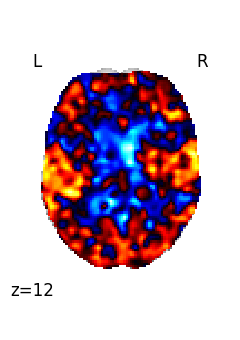

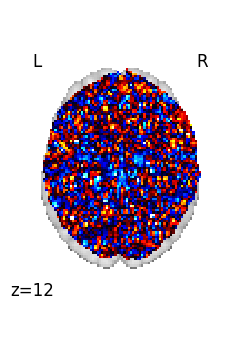

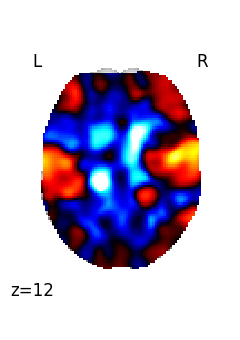

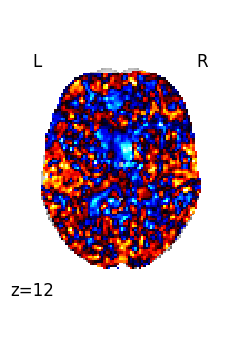

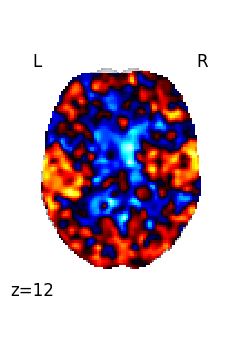

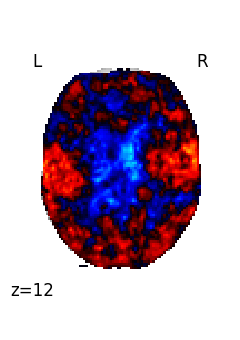

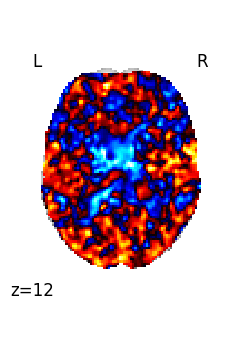

In [32]:
z_coords = [12]
img = nimg.load_img(os.path.join(basedir, "a0ac2cfb2dd5b4126a2685b9fd3dbbc684503b4254addc9ae133324b926667bf", '_subject_id_01', 'result.nii'))
plotting.plot_stat_map(img, cut_coords=z_coords, display_mode='z', vmin=-3, vmax=3, colorbar=False)

img = nimg.load_img(os.path.join(basedir, "77e348f1a75f714ef2dc0ea511d947e9a75313c49d4a8bc61af005e5e6b7d60e", '_subject_id_01', 'result.nii'))
plotting.plot_stat_map(img, cut_coords=z_coords, display_mode='z', vmin=-3, vmax=3, colorbar=False )
plt.show()

img = nimg.load_img(os.path.join(basedir, "2a1ceb762569a197fec6a7d42057663a9b2101b9d4e5dc077a720e3fcf9c4064", '_subject_id_01', 'result.nii'))
plotting.plot_stat_map(img, cut_coords=z_coords, display_mode='z', vmin=-3, vmax=3, colorbar=False)
plt.show()

img = nimg.load_img(os.path.join(basedir, "8a2c15247b6e5e3ca4367b3b26f513e93f6572b3abbbc2f18f7542ce4f255105", '_subject_id_01', 'result.nii'))
plotting.plot_stat_map(img, cut_coords=z_coords, display_mode='z', vmin=-3, vmax=3, colorbar=False)
plt.show()

img = nimg.load_img(os.path.join(basedir, "ref", '_subject_id_01', 'result.nii'))
# seuilage à 3.2
plotting.plot_stat_map(img, cut_coords=z_coords, display_mode='z', vmin=-3, vmax=3, colorbar=False)
plt.show()

img = nimg.load_img(os.path.join(basedir, 'mean_result.nii'))
# seuilage à 3.2
plotting.plot_stat_map(img, cut_coords=z_coords, display_mode='z', vmin=-3, vmax=3, colorbar=False)
plt.show()

img = nimg.load_img(os.path.join(basedir, "05a74cdcbd5faa976b866eec5a083de5e3945cc85a8971c44863127732e7026d", '_subject_id_01', 'result.nii'))
# seuilage à 3.2
plotting.plot_stat_map(img, cut_coords=z_coords, display_mode='z', vmin=-3, vmax=3, colorbar=False)
plt.show()


# Ref correlations repartition

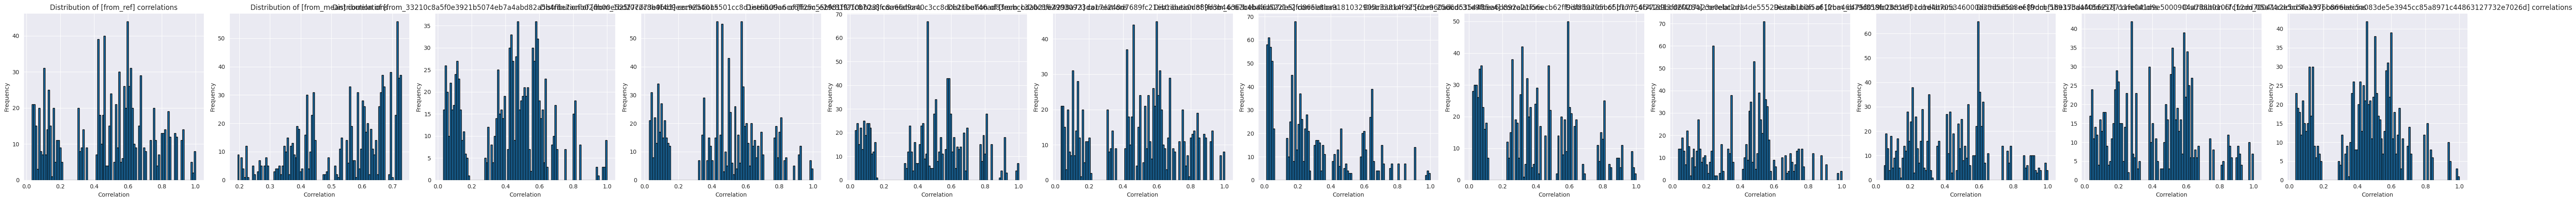

In [33]:
num_plots = len(target_vars)
fig, axes = plt.subplots(ncols=num_plots, figsize=(5 * num_plots, 5))

for i, corr in enumerate(target_vars):
    axes[i].hist(dataset[corr], bins=100, edgecolor='black')
    axes[i].set_title(f'Distribution of [{corr}] correlations')
    axes[i].set_xlabel('Correlation')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


# Stats maps QC

In [ ]:
def write_mean_image(self, images: list[str], path):
    matrices = []
    header = None
    affine = None
    print(f"Computing mean nifti image from [{len(images)}] images...")
    for img in images:
        loaded = nib.load(img)
        matrices.append(loaded.get_fdata())
        if not header:
            header = loaded.header.copy()
            affine = loaded.affine
    mean = nib.Nifti1Image(np.average(matrices, axis=0), affine, header)
    nib.save(mean, path)
    print(f"Mean nifti image written to [{path}]")
    return os.path.join(path)

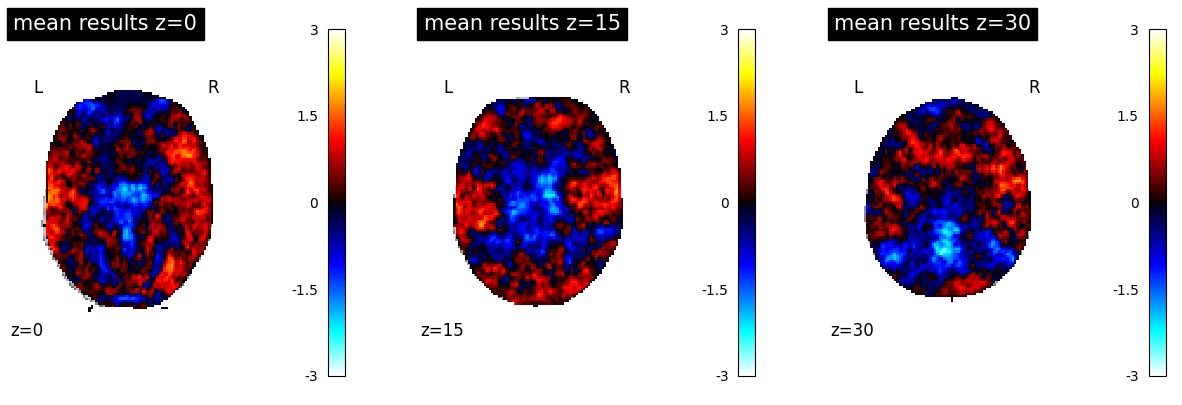

/home/ymerel/fmri-feature-model/.venv/lib64/python3.13/site-packages/nilearn/plotting/displays/_slicers.py:313: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)
/home/ymerel/tmp/ipykernel_39638/4089293554.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


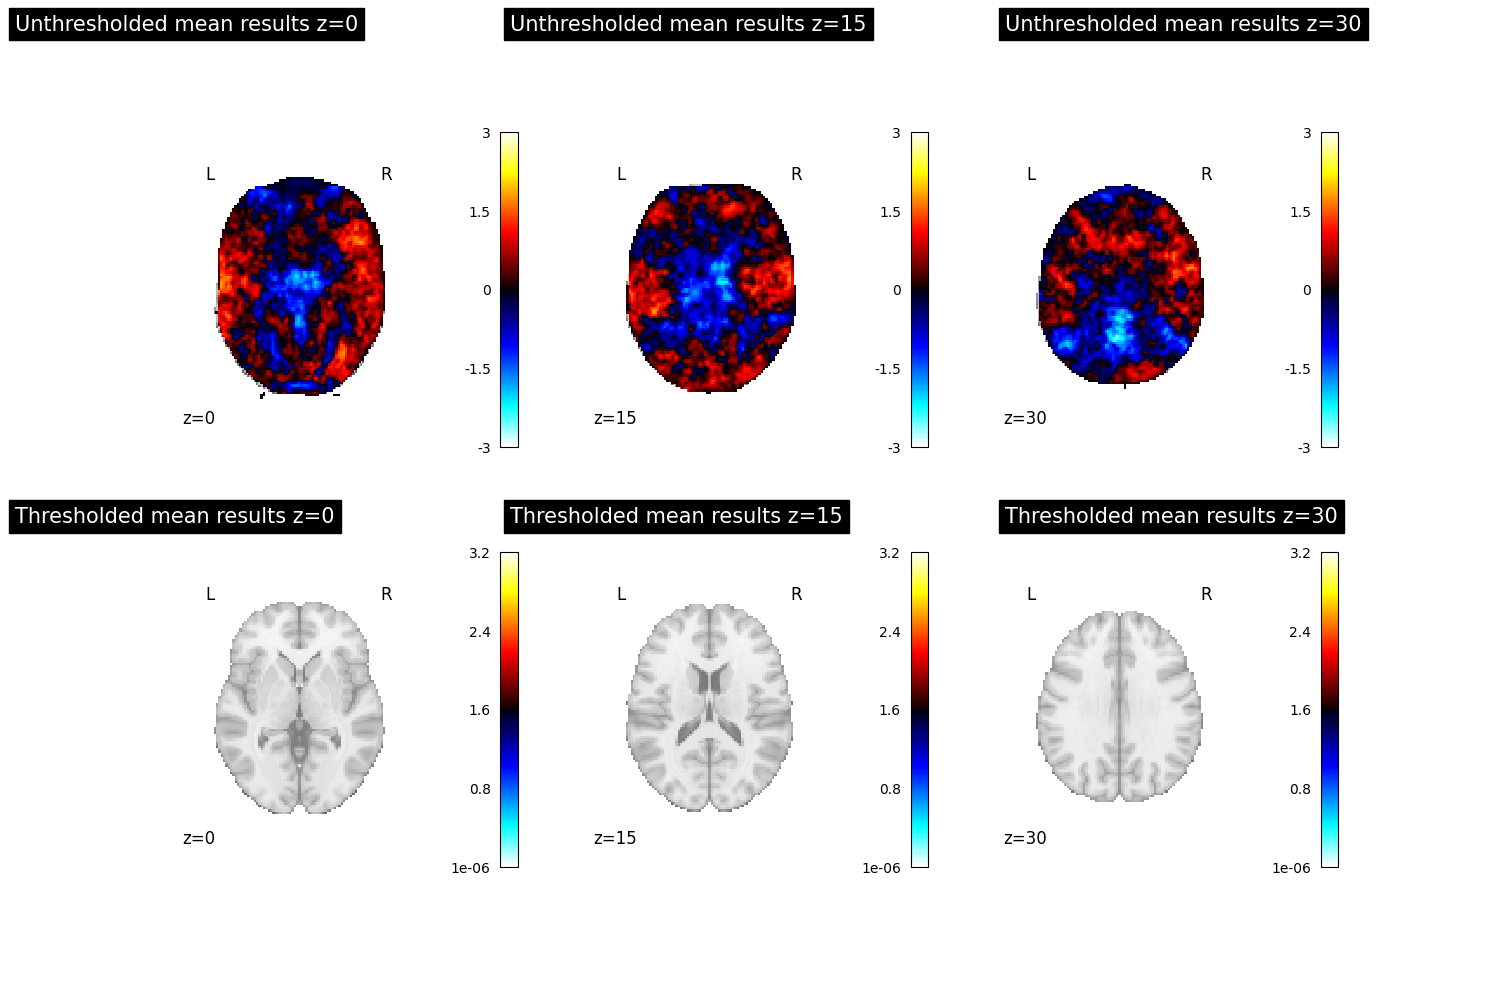

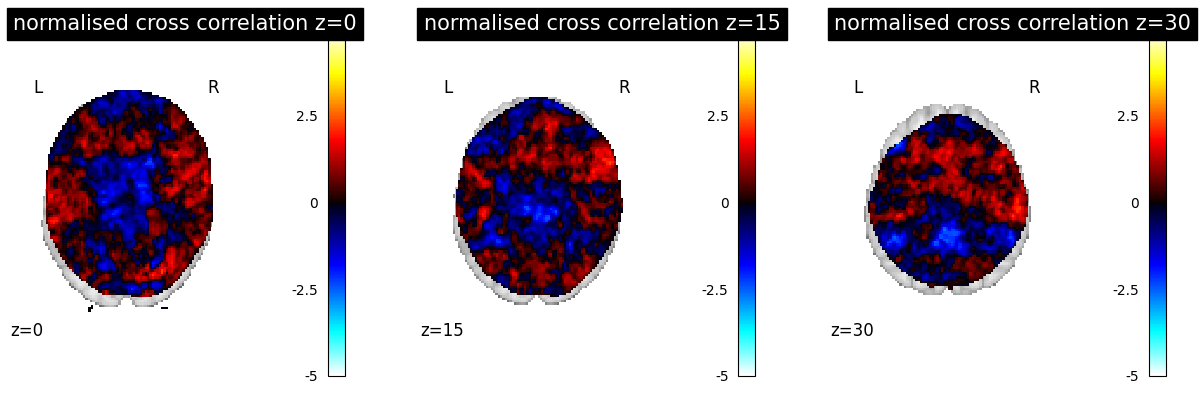

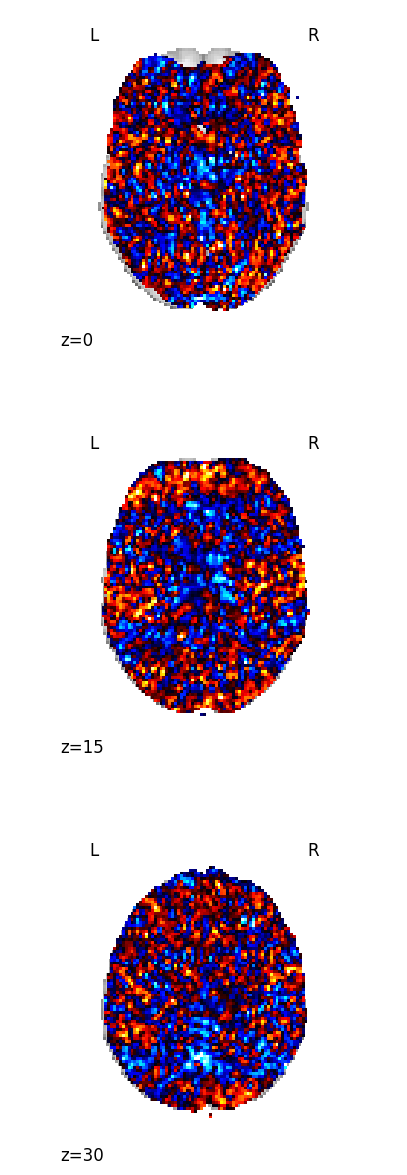

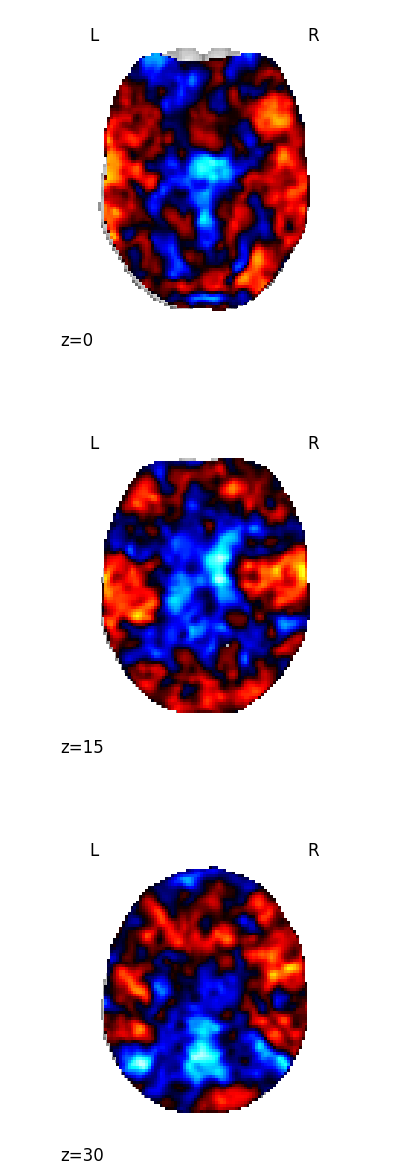

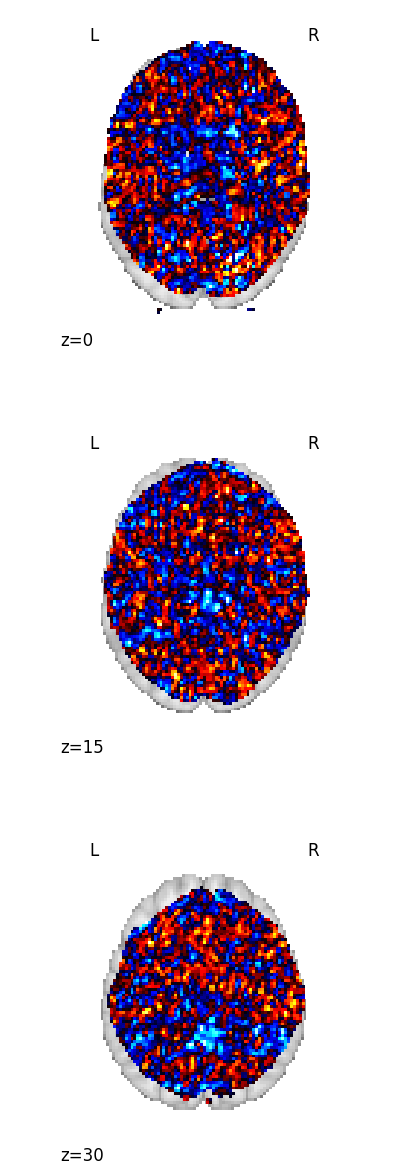

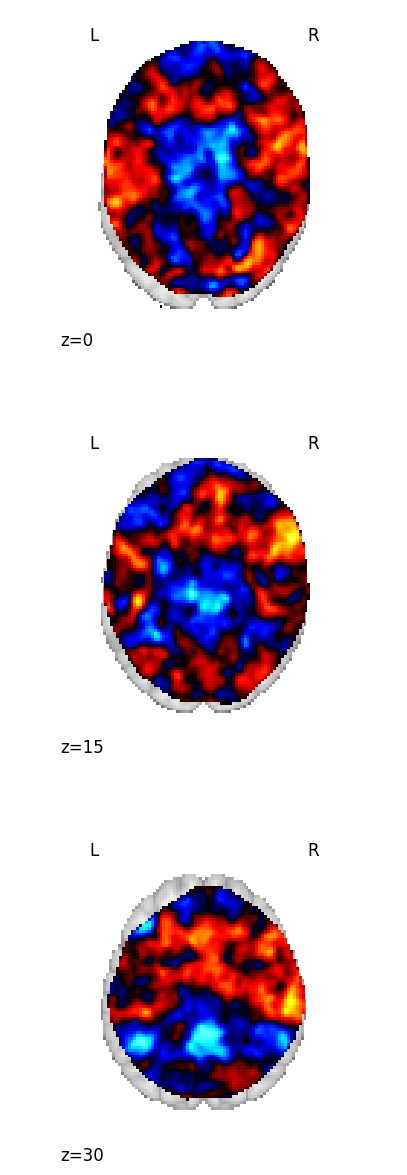

In [23]:
z_coords = [0, 15, 30]
img = nimg.load_img(os.path.join(basedir, 'mean_result.nii'))
label = 'mean results'
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, z_coord in enumerate(z_coords):
    plotting.plot_stat_map(img, cut_coords=[z_coord], display_mode='z', axes=axes[i], vmin=-3, vmax=3, title=f"{label} z={z_coord}")
plt.show()

# img = nimg.load_img(os.path.join(basedir, 'ref', '_subject_id_01', 'result.nii'))
# label = 'reference config'
# # seuilage à 3.2
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# for i, z_coord in enumerate(z_coords):
#     plotting.plot_stat_map(img, cut_coords=[z_coord], display_mode='z', axes=axes[i], vmin=-3, vmax=3, title=f"{label} z={z_coord}")
# plt.show()


# Create subplots: 2 rows for thresholded and unthresholded, and 3 columns for different z coordinates
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot unthresholded data in the first row
for i, z_coord in enumerate(z_coords):
    plotting.plot_stat_map(img, cut_coords=[z_coord], display_mode='z', axes=axes[0, i],
                           vmin=-3, vmax=3, title=f"Unthresholded {label} z={z_coord}")

# Define the threshold value
threshold = 3.2
# Get the image data as a numpy array
img_data = img.get_fdata()
# Apply the threshold to create a masked image
masked_data = np.where(img_data >= threshold, img_data, 0)
# Create a new Nifti1Image with the masked data
masked_img = nimg.new_img_like(img, masked_data)
# Plot thresholded data in the second row
for i, z_coord in enumerate(z_coords):
    plotting.plot_stat_map(masked_img, cut_coords=[z_coord], display_mode='z', axes=axes[1, i],
                           vmax=3.2, title=f"Thresholded {label} z={z_coord}")

plt.tight_layout()
plt.show()

# confs_ncc = dataset.loc[dataset["coregistration/cost_function/normalised_cross_correlation"] == True, 'id'].tolist()
# imgs = []
# for path in results:
#     for id in confs_ncc:
#         if id in path:
#             imgs.append(path)
# 
path = os.path.join(basedir, 'ncc_mean_result.nii')
# write_mean_image(imgs, path)
img = nimg.load_img(path)
label = 'normalised cross correlation'
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, z_coord in enumerate(z_coords):
    plotting.plot_stat_map(img, cut_coords=[z_coord], display_mode='z', axes=axes[i], vmin=-5, vmax=5, title=f"{label} z={z_coord}")
plt.show()

id_by_cluster = dataset.groupby('cluster')['id'].apply(list).to_dict()
for cluster, configs in id_by_cluster.items():
    # imgs = []
    # for path in results:
    #     for config in configs:
    #         if config in path:
    #             imgs.append(path)
    path = os.path.join(basedir, f'cluster_{cluster}_mean_result.nii')
    # write_mean_image(imgs, path)
    img = nimg.load_img(path)
    label = f'cluster {cluster}'
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    for i, z_coord in enumerate(z_coords):
        plotting.plot_stat_map(img, cut_coords=[z_coord], display_mode='z', axes=axes[i], vmin=-3, vmax=3, colorbar=False)
    plt.show()

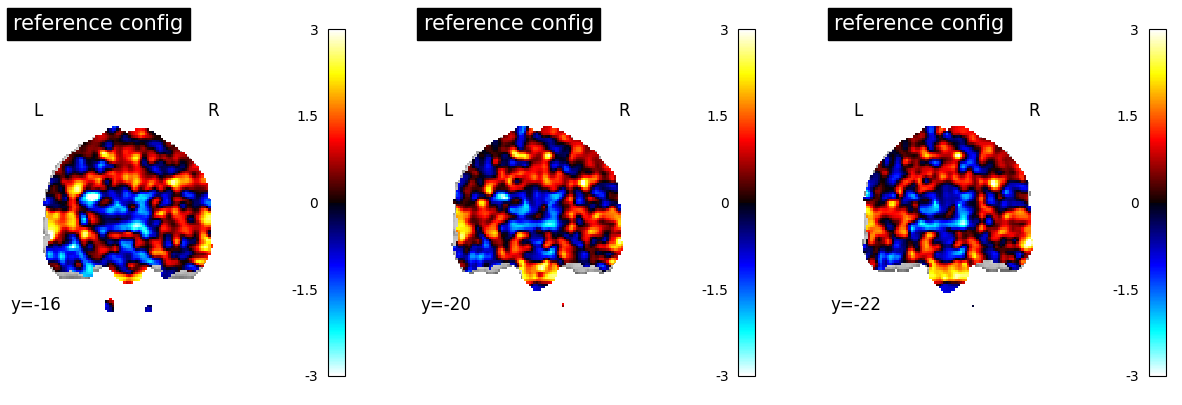

In [35]:
y_coords = [-16, -20, -22]
img = nimg.load_img(os.path.join(basedir, 'ref', '_subject_id_01', 'result.nii'))
label = 'reference config'
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, y_coord in enumerate(y_coords):
    plotting.plot_stat_map(img, cut_coords=[y_coord], display_mode='y', axes=axes[i], vmin=-3, vmax=3, title=f"{label}")
plt.show()

# Fit regressor decision tree model for all correlations metrics
- Try to predict the correlations for each configuration
- mean of correlations is computed independently for each train, test subset

Fit model for [from_ref]
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
from_ref : 10.66254077192168
from_ref Max MAPE : 11.693503660071071
from_ref min MAPE : 9.788284864301275
Fit model for [from_mean]
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
from_mean : 4.3159498871114605
from_mean Max MAPE : 7.377426399749903
from_mean min MAPE : 3.383810491137783
Fit model for [from_33210c8a5f0e3921b5074eb7a4abd82a5b4f6e7acfb02db00e525f07dc8b4bd3]
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
from_33210c8a5f0e3921b5074eb7a4abd82a5b4f6e7acfb02db00e525f07dc8b4bd3 : 8.835532682724576
from_33210c8a5f0e3921b5074eb7a4abd82a5b4f6e7acfb02db00e525f07dc8b4bd3 Max MAPE : 9.32583549192086
from_33210c8a5f0e3921b5074eb7a4abd82a5b4f6e7acfb02db00e525f07dc8b4bd3 min MAPE : 8.41755643088229

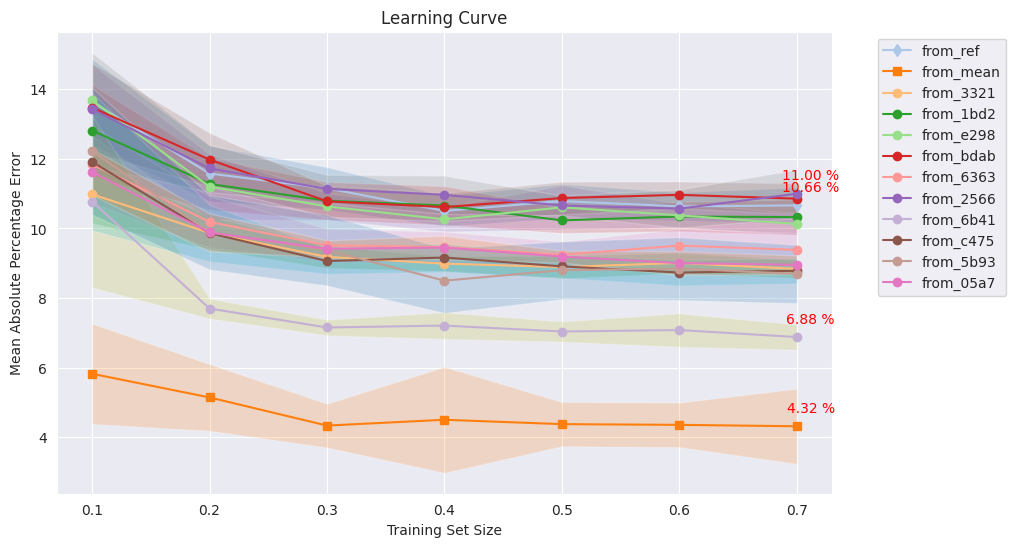

In [17]:
X = dataset['id']
y = dataset['id']
results = []
feat_reg_importances = []
train_sizes = np.linspace(0.1, 0.7, 7).tolist()
num_iterations = 10

plt.figure(figsize=(10, 6))
colormap = plt.cm.tab20
m=0
for metric in target_vars:
    m+=1
    print(f"Fit model for [{metric}]")
    
    from_mean = (metric == 'from_mean')

    # Initialize matrix to store results
    mape_matrix = np.zeros((num_iterations, len(train_sizes)))

    for i in range(num_iterations):
        print(f"Iteration {i + 1}")
        test_scores = []
        for train_size in train_sizes:
            train_size = round(train_size, 1)

            X_id_train, X_id_test, y_id_train, y_id_test = train_test_split(X, y, train_size=train_size)
            
            if from_mean:
                X_train = pd.read_csv(os.path.join(basedir, f'sub_dataset_{int(train_size*1000)}_train_{i+1}.csv'), delimiter=';')
                X_train = normalize_dataset(X_train)
                X_train['cluster'] = pd.Series([], dtype='float64')
            else:
                X_train = clusterize(X_id_train, 4)[0]
            y_train = X_train[metric]
            X_train = X_train.drop(columns=ignored)
            if from_mean:
                X_test = pd.read_csv(os.path.join(basedir, f'sub_dataset_{int(1000 - (train_size*1000))}_test_{i+1}.csv'), delimiter=';')
                X_test = normalize_dataset(X_test)
                X_test['cluster'] = pd.Series([], dtype='float64')
            else:
                X_test = clusterize(X_id_test, 4)[0]
            y_test = X_test[metric]
            X_test = X_test.drop(columns=ignored)

            # Train model
            regressor = DecisionTreeRegressor(max_depth=4)
            regressor.fit(X_train, y_train)

            y_pred = regressor.predict(X_test)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            score = mape * 100  # Negative because it's a loss metric
            test_scores.append(score)

            if train_size == 0.7:
                dot_data = tree.export_graphviz(regressor, out_file=None,
                                                feature_names=X_train.columns.values,
                                                filled=True, rounded=True,
                                                special_characters=True,
                                                leaves_parallel=True, proportion=True)
                graph = graphviz.Source(dot_data)
                graph.render(f"{metric}")
        
                features = dataset.drop(columns=ignored).columns
                importances = regressor.feature_importances_
                for j, feat in enumerate(features):
                    feat_reg_importances.append((metric, feat, importances[j]))
        
        # Store results in matrix
        mape_matrix[i, :] = test_scores

    # Calculate mean and standard deviation
    mean_mape = np.mean(mape_matrix, axis=0)
    print(f'{metric} : {mean_mape[6]}')
    std_mape = np.std(mape_matrix, axis=0)
    print(f"{metric} Max MAPE : {np.max(mape_matrix[:, -1], axis=0)}")
    print(f"{metric} min MAPE : {np.min(mape_matrix[:, -1], axis=0)}")

    # Plotting
    marker='o'
    if metric == 'from_ref':
        marker='d'
    elif metric == 'from_mean':
        marker='s'
    plt.plot(train_sizes, mean_mape, marker=marker, label=f'{metric[:9]}', color=colormap(m))
    # Annotate the last point
    if metric in ['from_mean', 'from_ref', 'from_6b4189bcd2f407a23e0ebc2d14de55529eaab1b0f5a612ba46b79d019b03cc46', 'from_2566dc31e9fbea6d892a21f56ecb62ff9df850705b65b17754f772d13f060284']:
        plt.annotate(f'{mean_mape[-1]:.2f} %',
                 (train_sizes[-1], mean_mape[-1]),
                 textcoords="offset points",
                 xytext=(10, 10),
                 ha='center',
                 fontsize=10,
                 color='red')
    plt.fill_between(train_sizes, mean_mape - std_mape, mean_mape + std_mape, alpha=0.2)
    results.append((metric, train_sizes, mean_mape, std_mape))

# Place the legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Percentage Error')
plt.title('Learning Curve')
plt.grid(True)
plt.show()

In [19]:
importance_df = pd.DataFrame(feat_reg_importances, columns=['Metric', 'Feature', 'Importance']).sort_values(by='Importance', ascending=False)
importance_df = importance_df[importance_df['Importance'] > 0]
aggregated_importance = importance_df.groupby(['Metric', 'Feature']).agg(
    Mean_Importance=('Importance', 'mean'),
    Min_Importance=('Importance', 'min'),
    Max_Importance=('Importance', 'max')
).reset_index()
aggregated_importance.head(500)

,Metric,Feature,Mean_Importance,Min_Importance,Max_Importance
0,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85...,coregistration/cost_function/normalised_cross_...,0.743259,0.731553,0.768670
1,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85...,signal_modeling/hrf/temporal_dispersion_derivs,0.096297,0.082942,0.104048
2,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85...,slice_timing_correction/ref_slice/first,0.004483,0.003729,0.005180
3,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85...,spatial_smoothing/fwhm,0.155961,0.143909,0.167760
4,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6...,coregistration/cost_function/normalised_cross_...,0.759417,0.738769,0.773699
5,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6...,signal_modeling/hrf/temporal_dispersion_derivs,0.059996,0.054898,0.063535
6,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6...,slice_timing_correction/ref_slice/first,0.055758,0.049038,0.060907
7,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6...,spatial_smoothing/fwhm,0.124829,0.112997,0.140202
8,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705...,coregistration/cost_function/normalised_cross_...,0.585310,0.557910,0.610794
9,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705...,signal_modeling/hrf/temporal_dispersion_derivs,0.028265,0.000306,0.038458


# Fit classifier decision tree model for clusters
- Try to predict the cluster of each configuration
- Clustering is recomputed independently for test, train subsets

Fit model for [cluster]
Iteration 1, Current train size: 0.1
              precision    recall  f1-score   support

           1       1.00      0.71      0.83       506
           2       0.54      1.00      0.70       173
           3       1.00      0.73      0.84       157
           4       0.60      1.00      0.75        64

    accuracy                           0.79       900
   macro avg       0.78      0.86      0.78       900
weighted avg       0.88      0.79      0.80       900

Iteration 1, Current train size: 0.2
              precision    recall  f1-score   support

           1       1.00      0.70      0.82       447
           2       0.53      1.00      0.69       151
           3       1.00      0.86      0.92       146
           4       0.73      1.00      0.84        56

    accuracy                           0.81       800
   macro avg       0.81      0.89      0.82       800
weighted avg       0.89      0.81      0.82       800

Iteration 1, Current train size:

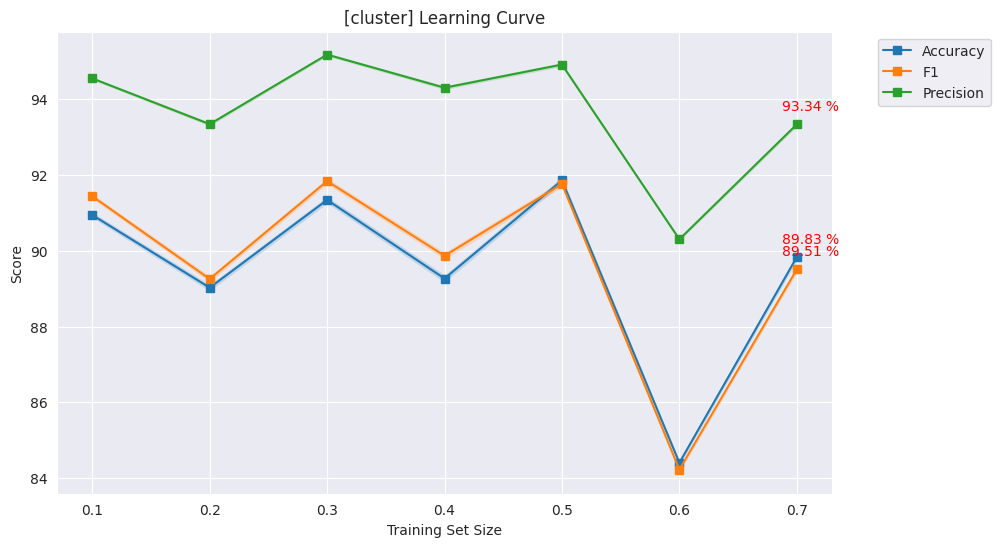

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report
import graphviz

metric = 'cluster'
results = []
feat_importances = []

print(f"Fit model for [{metric}]")

X = dataset['id']
y = dataset['id']

train_sizes = np.linspace(0.1, 0.7, 7).tolist()
num_iterations = 10

# Initialize matrices to store results
accuracy_matrix = np.zeros((num_iterations, len(train_sizes)))
f1_matrix = np.zeros((num_iterations, len(train_sizes)))
precision_matrix = np.zeros((num_iterations, len(train_sizes)))

for iteration in range(num_iterations):
    test_scores_acc = []
    test_scores_f1 = []
    test_scores_prec = []

    for train_size in train_sizes:
        train_size = round(train_size, 1)
        print(f"Iteration {iteration + 1}, Current train size: {train_size}")
        X_id_train, X_id_test, y_id_train, y_id_test = train_test_split(X, y, train_size=train_size)

        X_train = clusterize(X_id_train, 4)
        y_train = X_train[0]['cluster']
        X_train = X_train[0].drop(columns=ignored)

        X_test = clusterize(X_id_test, 4)
        y_test = X_test[0]['cluster']
        X_test = X_test[0].drop(columns=ignored)

        classifier = DecisionTreeClassifier(random_state=42)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4']))

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')

        test_scores_acc.append(accuracy)
        test_scores_f1.append(f1)
        test_scores_prec.append(precision)

        if train_size == 0.7:
            dot_data = tree.export_graphviz(classifier, out_file=None,
                                             feature_names=X_train.columns.values,
                                             filled=True, rounded=True,
                                             special_characters=True,
                                             leaves_parallel=True, proportion=True)
            graph = graphviz.Source(dot_data)
            graph.render(f"{metric}")

            features = dataset.drop(columns=ignored).columns
            importances = classifier.feature_importances_
            for i, feat in enumerate(features):
                feat_importances.append((metric, feat, importances[i]))

    # Store results in matrices
    accuracy_matrix[iteration, :] = test_scores_acc
    f1_matrix[iteration, :] = test_scores_f1
    precision_matrix[iteration, :] = test_scores_prec

# Calculate mean and standard deviation
mean_accuracy = np.mean(accuracy_matrix, axis=0)
print(f"Max accuracy : {np.max(accuracy_matrix, axis=0)}")
print(f"min accuracy : {np.min(accuracy_matrix, axis=0)}")
std_accuracy = np.std(accuracy_matrix, axis=0)
mean_f1 = np.mean(f1_matrix, axis=0)
print(f"Max f1 : {np.max(f1_matrix, axis=0)}")
print(f"min f1 : {np.min(f1_matrix, axis=0)}")
std_f1 = np.std(f1_matrix, axis=0)
mean_precision = np.mean(precision_matrix, axis=0)
print(f"Max precision : {np.max(precision_matrix, axis=0)}")
print(f"min precision : {np.min(precision_matrix, axis=0)}")
std_precision = np.std(precision_matrix, axis=0)


# Plotting
mean_score = mean_accuracy * 100
std_score = std_accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, mean_score, marker='s', label=f'Accuracy')
plt.fill_between(train_sizes, mean_score - std_score, mean_score + std_score, alpha=0.2)
plt.annotate(f'{mean_score[-1]:.2f} %',
                 (train_sizes[-1], mean_score[-1]),
                 textcoords="offset points",
                 xytext=(10, 10),
                 ha='center',
                 fontsize=10,
                 color='red')
mean_score = mean_f1 * 100
std_score = std_f1
plt.plot(train_sizes, mean_score, marker='s', label=f'F1')
plt.fill_between(train_sizes, mean_score - std_score, mean_score + std_score, alpha=0.2)
plt.annotate(f'{mean_score[-1]:.2f} %',
                 (train_sizes[-1], mean_score[-1]),
                 textcoords="offset points",
                 xytext=(10, 10),
                 ha='center',
                 fontsize=10,
                 color='red')
mean_score = mean_precision * 100
std_score = std_precision
plt.plot(train_sizes, mean_score, marker='s', label=f'Precision')
plt.fill_between(train_sizes, mean_score - std_score, mean_score + std_score, alpha=0.2)
plt.annotate(f'{mean_score[-1]:.2f} %',
                 (train_sizes[-1], mean_score[-1]),
                 textcoords="offset points",
                 xytext=(10, 10),
                 ha='center',
                 fontsize=10,
                 color='red')

plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title(f'[{metric}] Learning Curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [13]:
importance_df = pd.DataFrame(feat_importances, columns=['Metric', 'Feature', 'Importance']).sort_values(by='Importance', ascending=False)
importance_df = importance_df[importance_df['Importance'] > 0]
# Group by 'metric' and 'feature', then calculate the mean of 'importance'
average_importance = importance_df.groupby(['Metric', 'Feature'])['Importance'].mean().reset_index()
average_importance.head(100)

,Metric,Feature,Importance
0,cluster,coregistration/cost_function/normalised_cross_...,0.545480
1,cluster,signal_modeling/hrf/temporal_dispersion_derivs,0.016141
2,cluster,slice_timing_correction/ref_slice/first,0.004259
3,cluster,spatial_smoothing/fwhm,0.452480


# Computational cost

In [ ]:
with open('/home/ymerel/storage/results/auditory/jobs.json', 'r') as file:
        data = json.load(file)

In [ ]:
jobs = []
run_hours = 0
post_hours = 0
times = []
for id, job in data['jobs'].items():
    if job['owner'] == 'ymerel' and job['state'] == 'Terminated':
        if job['command'] == '/home/ymerel/fmri-conf-runner/run_configs.sh':
            times.append((job['stop_time'] - job['start_time']) / 60)
            run_hours += (job['stop_time'] - job['start_time']) / 3600
        if job['command'] == '/home/ymerel/fmri-conf-runner/postprocess.sh':
            post_hours += (job['stop_time'] - job['start_time']) / 3600
        jobs.append(job)
print(f"[pipelines] Total runtime (h) : {run_hours}")
print(f"[pipelines] Runtime per pipelines (min) : {(run_hours / 1000)*60}")
print(f"[postprocessing] Total runtime (h) : {post_hours}")